In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Qinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [4]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)


In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [6]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 64s 1ms/step - loss: 26.5025 - val_loss: 16.4374
Epoch 2/50
45000/45000 [==============================] - 65s 1ms/step - loss: 16.0045 - val_loss: 15.4867
Epoch 3/50
45000/45000 [==============================] - 75s 2ms/step - loss: 15.7691 - val_loss: 15.9861
Epoch 4/50
45000/45000 [==============================] - 63s 1ms/step - loss: 15.3350 - val_loss: 15.1828
Epoch 5/50
45000/45000 [==============================] - 62s 1ms/step - loss: 15.1540 - val_loss: 15.0638
Epoch 6/50
45000/45000 [==============================] - 63s 1ms/step - loss: 15.1230 - val_loss: 14.9178
Epoch 7/50
45000/45000 [==============================] - 68s 2ms/step - loss: 15.0130 - val_loss: 14.9068
Epoch 8/50
45000/45000 [==============================] - 67s 1ms/step - loss: 14.8951 - val_loss: 14.7819
Epoch 9/50
45000/45000 [==============================] - 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


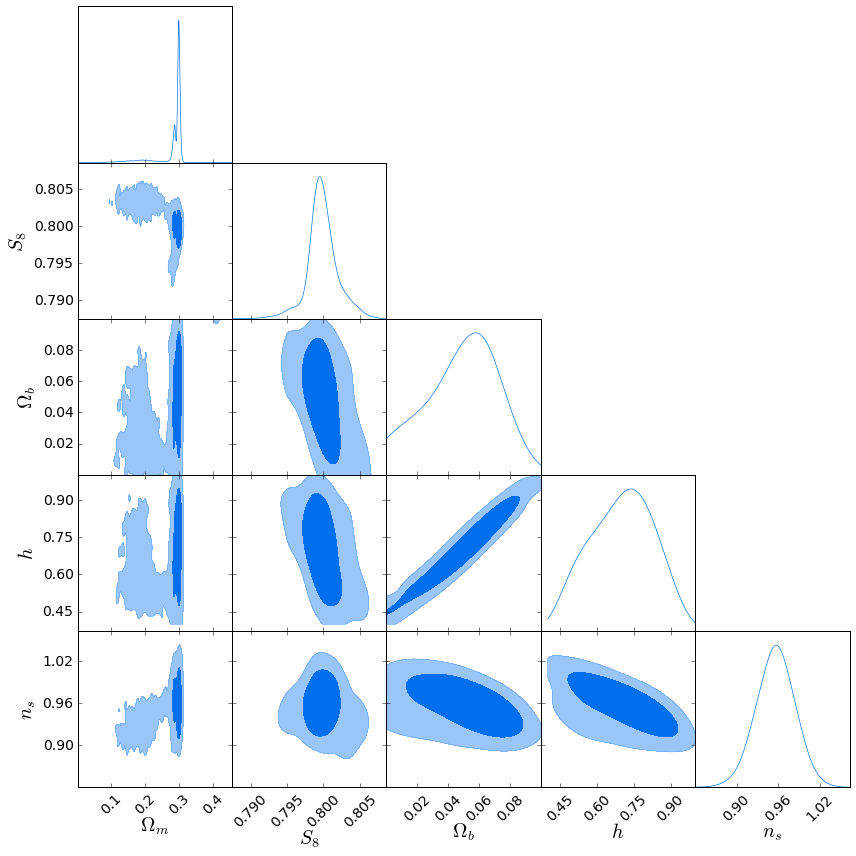

In [7]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=50)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 2ms/step - loss: 9.3378 - val_loss: 7.2063
Epoch 2/100
450/450 [==============================] - 1s 2ms/step - loss: 8.0176 - val_loss: 6.9366
Epoch 3/100
450/450 [==============================] - 1s 2ms/step - loss: 7.2203 - val_loss: 6.9784
Epoch 4/100
450/450 [==============================] - 1s 2ms/step - loss: 6.9145 - val_loss: 6.5141
Epoch 5/100
450/450 [==============================] - 1s 2ms/step - loss: 6.6730 - val_loss: 6.3469
Epoch 6/100
450/450 [==============================] - 1s 2ms/step - loss: 6.5086 - val_loss: 6.2438
Epoch 7/100
450/450 [==============================] - 1s 2ms/step - loss: 6.3445 - val_loss: 6.0200
Epoch 8/100
450/450 [==============================] - 1s 2ms/step - loss: 6.2058 - val_loss: 6.0670
Epoch 9/100
450/450 [==============================] - 1s 2ms/step - loss: 6.1652 - val_loss: 5.9850
Epoch 10/100

450/450 [==============================] - 1s 2ms/step - loss: 4.7498 - val_loss: 4.8290
Epoch 81/100
450/450 [==============================] - 1s 2ms/step - loss: 4.7332 - val_loss: 4.7695
Epoch 82/100
450/450 [==============================] - 1s 2ms/step - loss: 4.7775 - val_loss: 4.8267
Epoch 83/100
450/450 [==============================] - 1s 2ms/step - loss: 4.6784 - val_loss: 4.9932
Epoch 84/100
450/450 [==============================] - 1s 2ms/step - loss: 4.7652 - val_loss: 4.7459
Epoch 85/100
450/450 [==============================] - 1s 2ms/step - loss: 4.6884 - val_loss: 4.7581
Epoch 86/100
450/450 [==============================] - 1s 2ms/step - loss: 4.6293 - val_loss: 4.8765
Epoch 87/100
450/450 [==============================] - 1s 2ms/step - loss: 4.6296 - val_loss: 4.8139
Epoch 88/100
450/450 [==============================] - 1s 2ms/step - loss: 4.7250 - val_loss: 4.8358
Epoch 89/100
450/450 [==============================] - 1s 2ms/step - loss: 4.7974 - val_loss: 

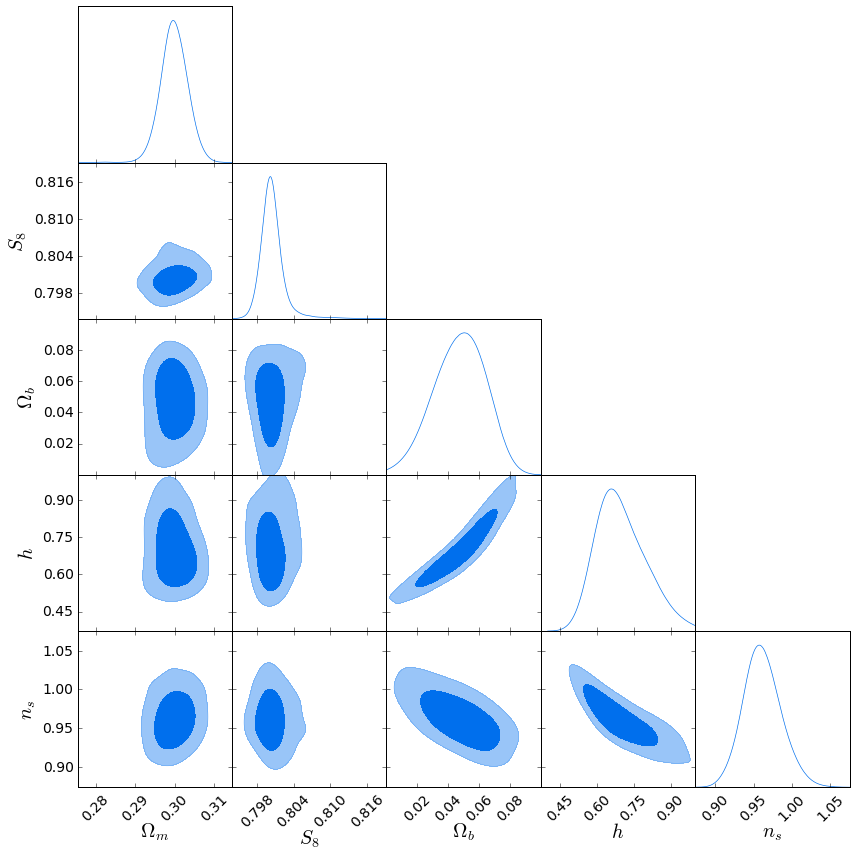

Population 1/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 4.8991 - val_loss: 4.2455
Epoch 2/100
900/900 [==============================] - 2s 2ms/step - loss: 4.7661 - val_loss: 4.2236
Epoch 3/100
900/900 [==============================] - 2s 2ms/step - loss: 4.7003 - val_loss: 4.0917
Epoch 4/100
900/900 [==============================] - 2s 2ms/step - loss: 4.6374 - val_loss: 4.0809
Epoch 5/100
900/900 [==============================] - 2s 2ms/step - loss: 4.6386 - val_loss: 4.0258
Epoch 6/100
900/900 [==============================] - 2s 2ms/step - loss: 4.6005 - val_loss: 4.0667
Epoch 7/100
900/900 [==============================] - 2s 2ms/step - loss: 4.5902 - val_loss: 3.9999
Epoch 8/100
900/900 [==============================] - 2s 2ms/step - loss: 4.5777 - val_loss: 4.0246
Epoch 9/100
900/900 [==============================] - 2s 2ms/step - 

900/900 [==============================] - 2s 3ms/step - loss: 4.3973 - val_loss: 3.7477
Epoch 81/100
900/900 [==============================] - 2s 2ms/step - loss: 4.3007 - val_loss: 4.0865
Epoch 82/100
900/900 [==============================] - 2s 2ms/step - loss: 4.3162 - val_loss: 3.9158
Epoch 83/100
900/900 [==============================] - 2s 2ms/step - loss: 4.2819 - val_loss: 3.8263
Epoch 84/100
900/900 [==============================] - 2s 2ms/step - loss: 4.2626 - val_loss: 3.7689
Epoch 85/100
900/900 [==============================] - 2s 2ms/step - loss: 4.2871 - val_loss: 3.8041
Epoch 86/100
900/900 [==============================] - 2s 2ms/step - loss: 4.2587 - val_loss: 3.7580
Epoch 87/100
900/900 [==============================] - 2s 2ms/step - loss: 4.2554 - val_loss: 3.8577
Epoch 88/100
900/900 [==============================] - 2s 2ms/step - loss: 4.2854 - val_loss: 3.7866
Epoch 89/100
900/900 [==============================] - 2s 2ms/step - loss: 4.2893 - val_loss: 

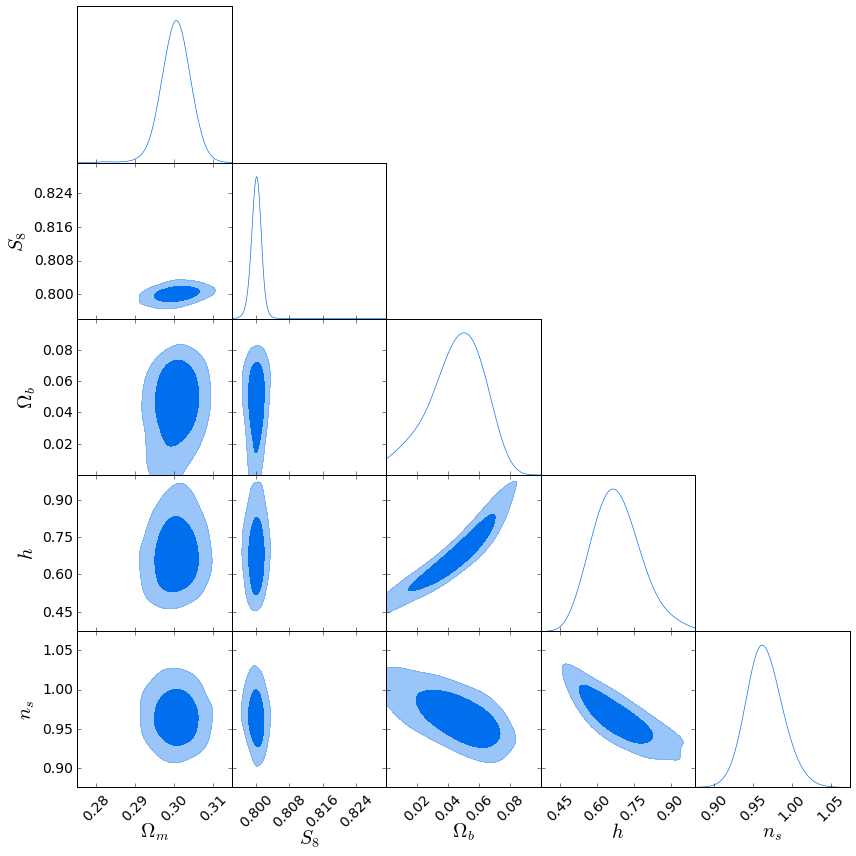

Population 2/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.3776 - val_loss: 3.9242
Epoch 2/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.3277 - val_loss: 3.8790
Epoch 3/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.3078 - val_loss: 3.8800
Epoch 4/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.2860 - val_loss: 3.8973
Epoch 5/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.2986 - val_loss: 3.9767
Epoch 6/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.3054 - val_loss: 3.9180
Epoch 7/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.3060 - val_loss: 3.9842
Epoch 8/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.3272 - val_loss: 3.8327
Epoch 9/100
1350/1350 [=============================

1350/1350 [==============================] - 3s 2ms/step - loss: 4.0889 - val_loss: 3.7467
Epoch 79/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.1100 - val_loss: 3.7492
Epoch 80/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.1381 - val_loss: 4.1323
Epoch 81/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.1480 - val_loss: 3.8517
Epoch 82/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.1394 - val_loss: 3.7502
Epoch 83/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.1354 - val_loss: 3.9177
Epoch 84/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.1500 - val_loss: 3.8685
Epoch 85/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.1112 - val_loss: 3.7730
Epoch 86/100
1350/1350 [==============================] - 3s 2ms/step - loss: 4.0917 - val_loss: 3.7578
Epoch 87/100
1350/1350 [==============================] - 3s 2ms/step - loss:

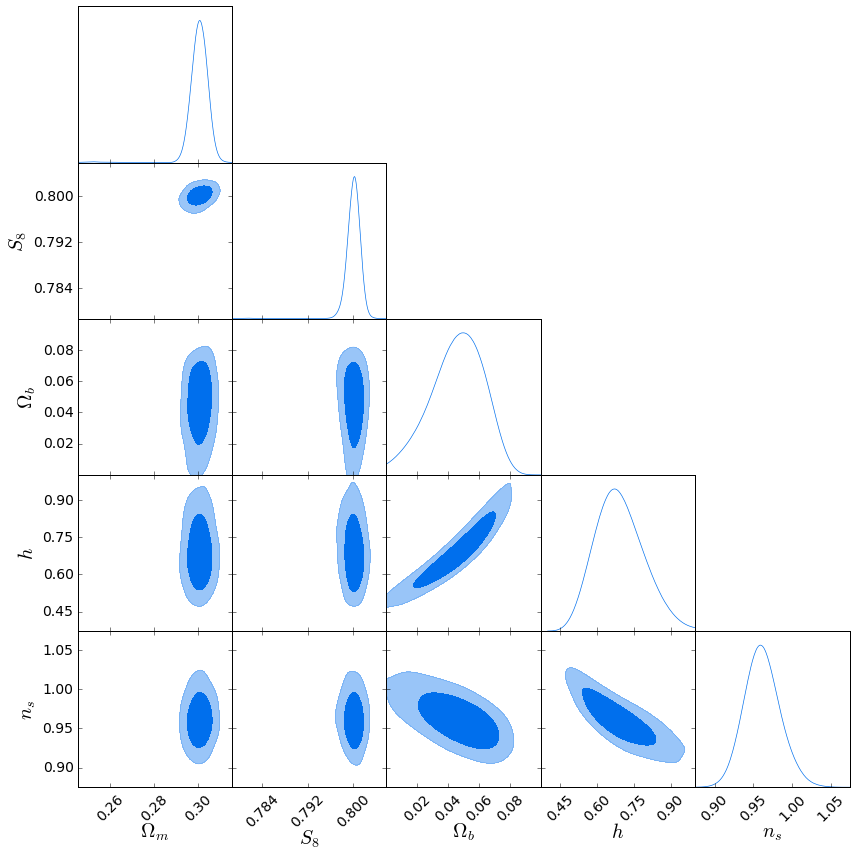

Population 3/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 4s 2ms/step - loss: 4.0227 - val_loss: 3.8057
Epoch 2/100
1800/1800 [==============================] - 4s 2ms/step - loss: 4.0174 - val_loss: 3.7659
Epoch 3/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9780 - val_loss: 3.8175
Epoch 4/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9961 - val_loss: 3.7686
Epoch 5/100
1800/1800 [==============================] - 4s 2ms/step - loss: 4.0346 - val_loss: 3.7579
Epoch 6/100
1800/1800 [==============================] - 4s 2ms/step - loss: 4.0306 - val_loss: 3.7108
Epoch 7/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9437 - val_loss: 3.7028
Epoch 8/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9851 - val_loss: 3.7557
Epoch 9/100
1800/1800 [=============================

1800/1800 [==============================] - 4s 2ms/step - loss: 3.9214 - val_loss: 3.7497
Epoch 79/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9664 - val_loss: 3.7607
Epoch 80/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9457 - val_loss: 3.6455
Epoch 81/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.8932 - val_loss: 3.6441
Epoch 82/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9101 - val_loss: 3.7485
Epoch 83/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9301 - val_loss: 3.8228
Epoch 84/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.9352 - val_loss: 3.7274
Epoch 85/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.8729 - val_loss: 3.6217
Epoch 86/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.8637 - val_loss: 3.6198
Epoch 87/100
1800/1800 [==============================] - 4s 2ms/step - loss:

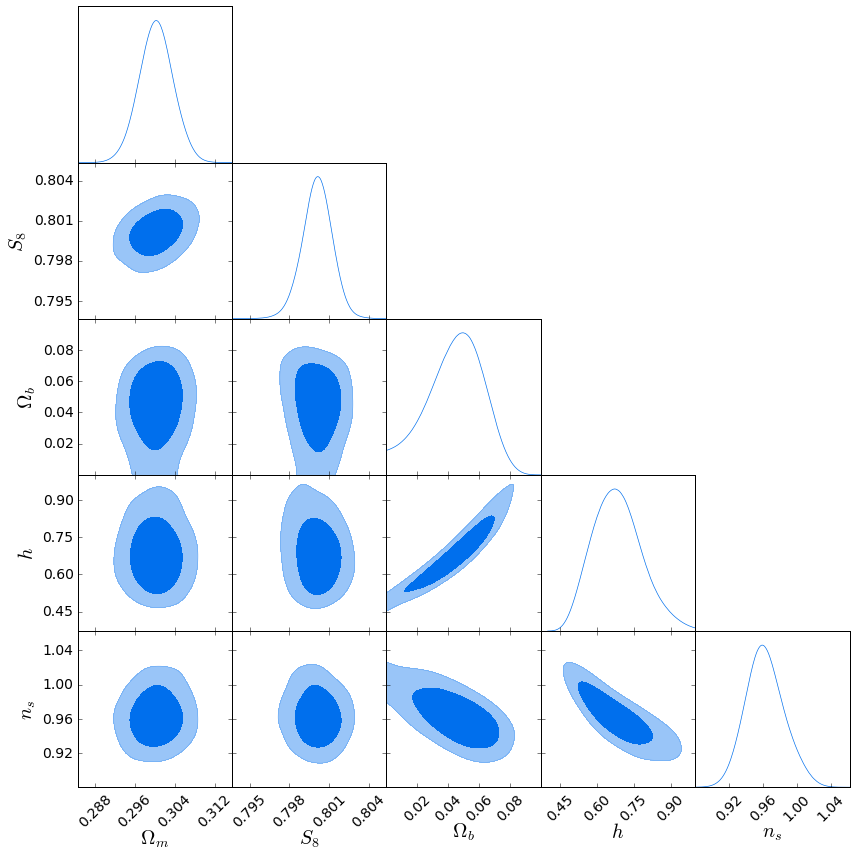

Population 4/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8411 - val_loss: 3.7807
Epoch 2/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8228 - val_loss: 3.8852
Epoch 3/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.9161 - val_loss: 3.7997
Epoch 4/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8373 - val_loss: 3.8321
Epoch 5/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.7901 - val_loss: 3.7175
Epoch 6/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.7969 - val_loss: 3.7736
Epoch 7/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.7949 - val_loss: 3.7335
Epoch 8/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8050 - val_loss: 3.7463
Epoch 9/100
2250/2250 [=============================

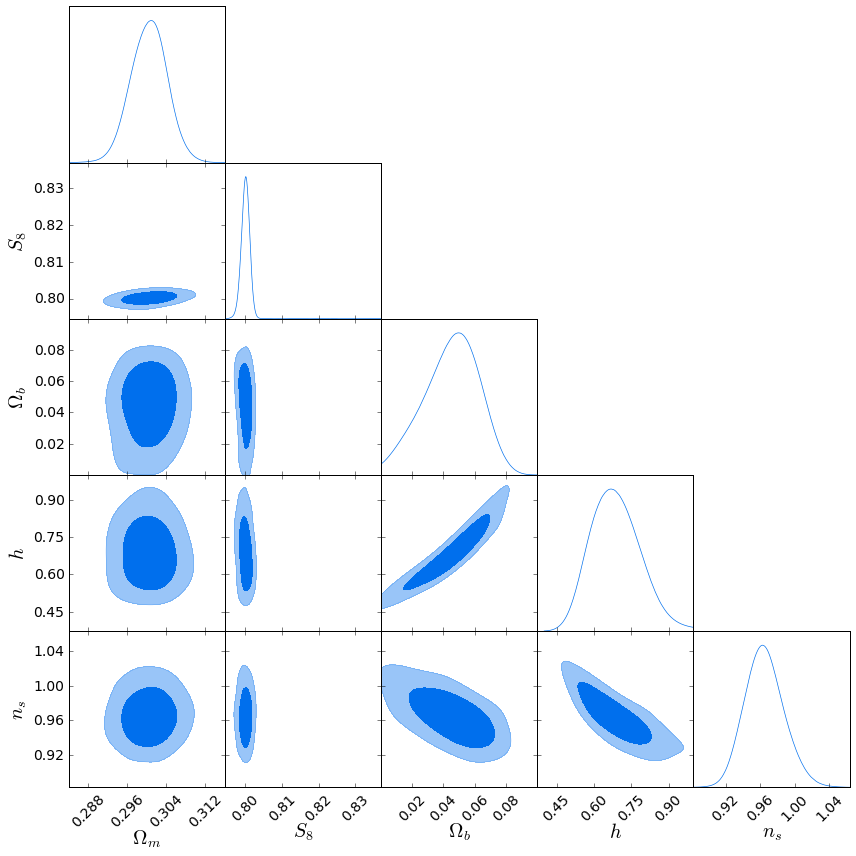

Population 5/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8872 - val_loss: 3.6602
Epoch 2/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8523 - val_loss: 3.9144
Epoch 3/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.7795 - val_loss: 3.6132
Epoch 4/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.7823 - val_loss: 3.6040
Epoch 5/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.7985 - val_loss: 3.5884
Epoch 6/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.7660 - val_loss: 3.5986
Epoch 7/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.7638 - val_loss: 3.6425
Epoch 8/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.7953 - val_loss: 3.8689
Epoch 9/100
2700/2700 [=============================

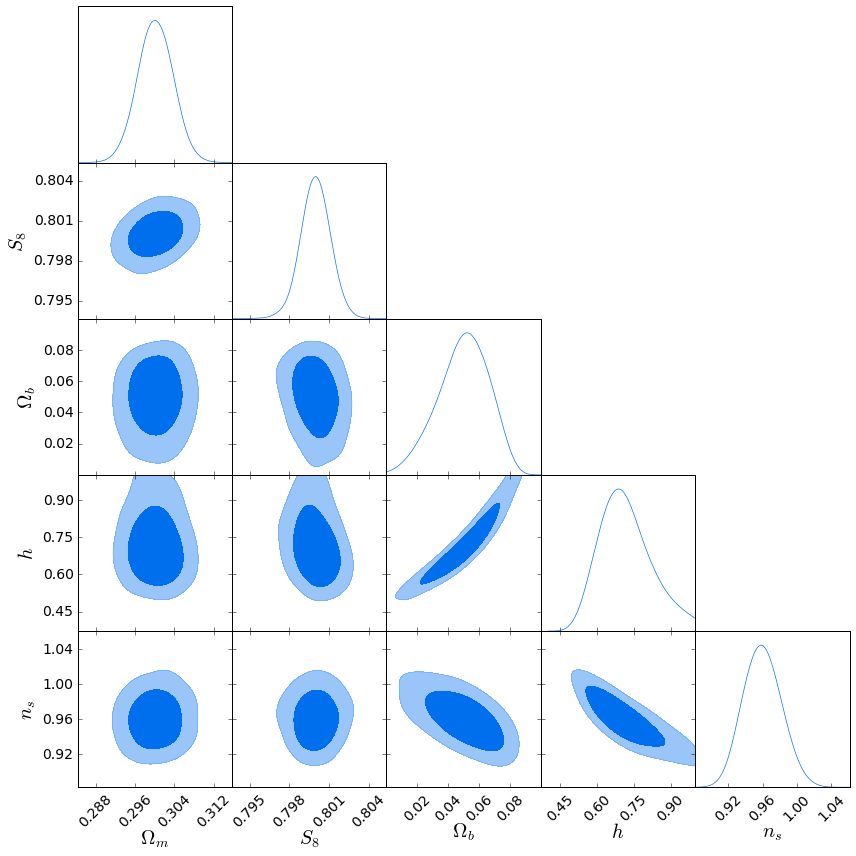

Population 6/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 8s 3ms/step - loss: 3.8056 - val_loss: 4.0831
Epoch 2/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.7805 - val_loss: 4.0828
Epoch 3/100
3150/3150 [==============================] - 8s 3ms/step - loss: 3.8009 - val_loss: 4.1120
Epoch 4/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.7921 - val_loss: 3.9200
Epoch 5/100
3150/3150 [==============================] - 8s 3ms/step - loss: 3.7603 - val_loss: 3.9298
Epoch 6/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.7521 - val_loss: 3.9714
Epoch 7/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.7559 - val_loss: 3.9466
Epoch 8/100
3150/3150 [==============================] - 8s 2ms/step - loss: 3.7585 - val_loss: 3.9658
Epoch 9/100
3150/3150 [=============================

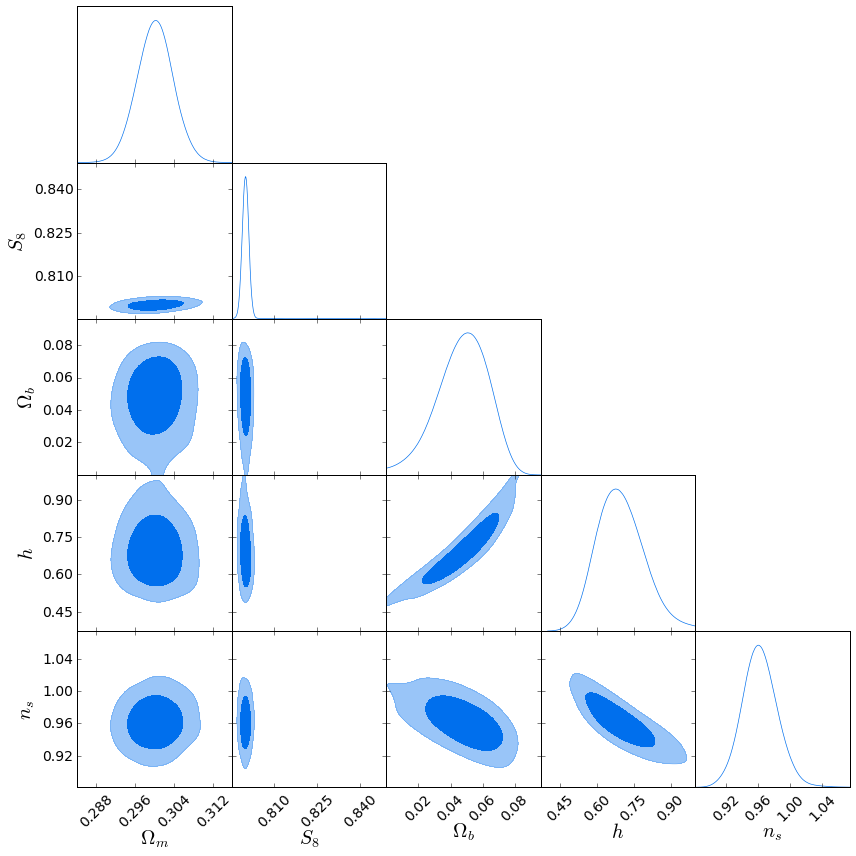

Population 7/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7878 - val_loss: 7.7242
Epoch 2/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7616 - val_loss: 7.6413
Epoch 3/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7483 - val_loss: 7.7519
Epoch 4/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7392 - val_loss: 7.6981
Epoch 5/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7412 - val_loss: 7.7266
Epoch 6/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7703 - val_loss: 7.5388
Epoch 7/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7391 - val_loss: 7.6385
Epoch 8/100
3600/3600 [==============================] - 8s 2ms/step - loss: 3.7497 - val_loss: 7.7895
Epoch 9/100
3600/3600 [=============================

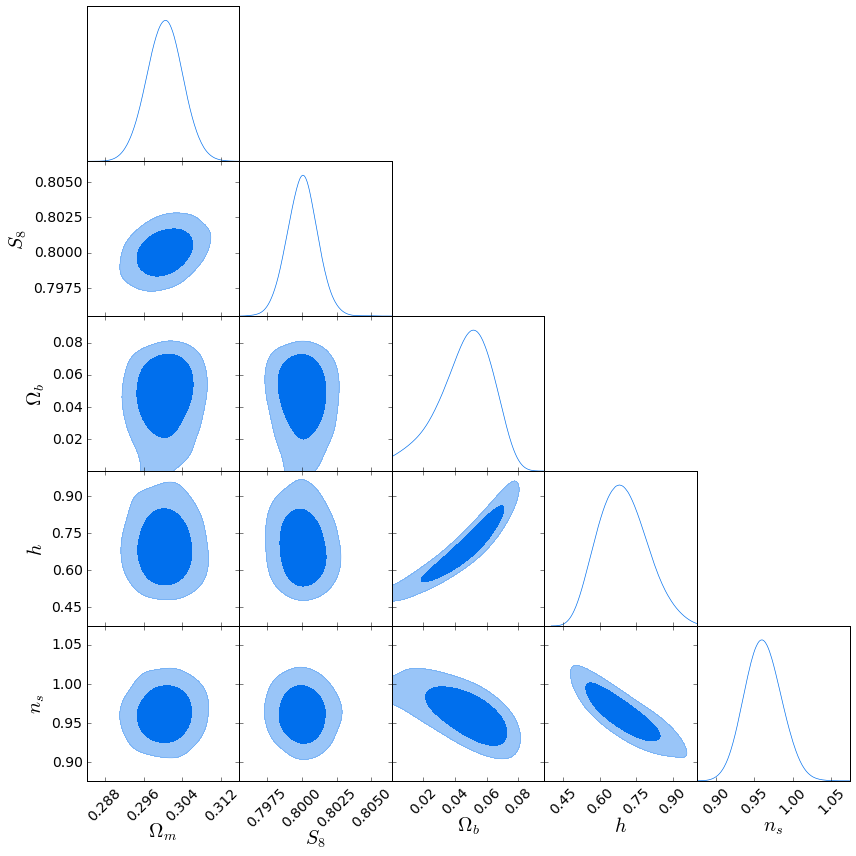

Population 8/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 7s 2ms/step - loss: 4.0718 - val_loss: 3.7178
Epoch 2/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.9639 - val_loss: 3.7699
Epoch 3/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.9325 - val_loss: 3.7361
Epoch 4/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.9129 - val_loss: 3.7312
Epoch 5/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.9249 - val_loss: 3.8262
Epoch 6/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.9230 - val_loss: 3.7473
Epoch 7/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.9058 - val_loss: 3.8197
Epoch 8/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.8822 - val_loss: 3.8226
Epoch 9/100
4050/4050 [=============================

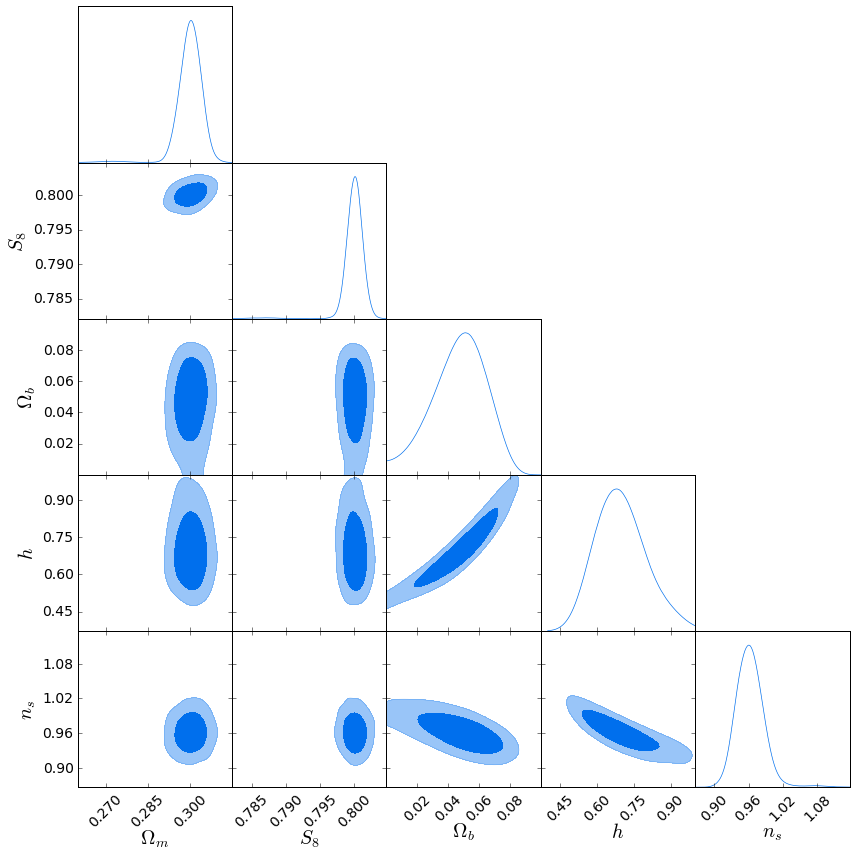

Population 9/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.8500 - val_loss: 3.5253
Epoch 2/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.8926 - val_loss: 3.6445
Epoch 3/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.8638 - val_loss: 3.4679
Epoch 4/100
4500/4500 [==============================] - 6s 1ms/step - loss: 3.8368 - val_loss: 3.4718
Epoch 5/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8371 - val_loss: 3.4687
Epoch 6/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8559 - val_loss: 3.5210
Epoch 7/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8816 - val_loss: 3.4603
Epoch 8/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8395 - val_loss: 3.4723
Epoch 9/100
4500/4500 [=============================

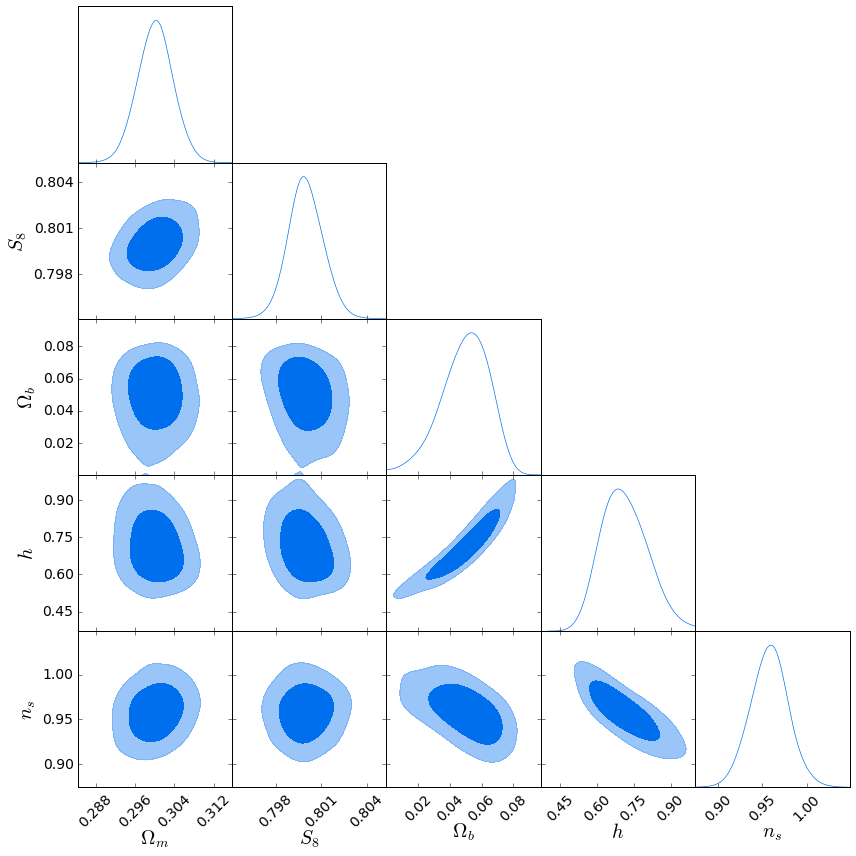

Population 10/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4950 samples, validate on 550 samples
Epoch 1/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.7812 - val_loss: 3.6314
Epoch 2/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.8334 - val_loss: 3.6859
Epoch 3/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.8408 - val_loss: 3.5798
Epoch 4/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.7877 - val_loss: 3.6028
Epoch 5/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.7729 - val_loss: 3.6206
Epoch 6/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.8353 - val_loss: 3.8062
Epoch 7/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.8492 - val_loss: 3.6259
Epoch 8/100
4950/4950 [==============================] - 11s 2ms/step - loss: 3.8006 - val_loss: 3.5752
Epoch 9/100
4950/4950 [====================

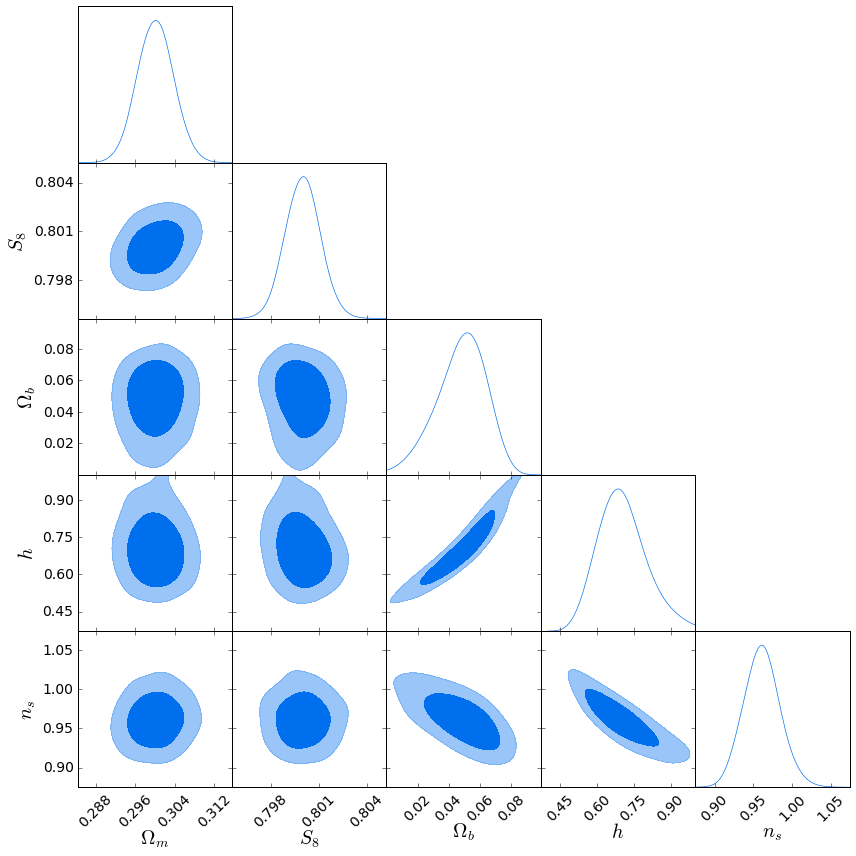

Population 11/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.7443 - val_loss: 3.6177
Epoch 2/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.7504 - val_loss: 3.7282
Epoch 3/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.8715 - val_loss: 3.6306
Epoch 4/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.7731 - val_loss: 3.6241
Epoch 5/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.7557 - val_loss: 3.5994
Epoch 6/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.7436 - val_loss: 3.6380
Epoch 7/100
5400/5400 [==============================] - 8s 2ms/step - loss: 3.7332 - val_loss: 3.6563
Epoch 8/100
5400/5400 [==============================] - 8s 2ms/step - loss: 3.7384 - val_loss: 3.6067
Epoch 9/100
5400/5400 [============================

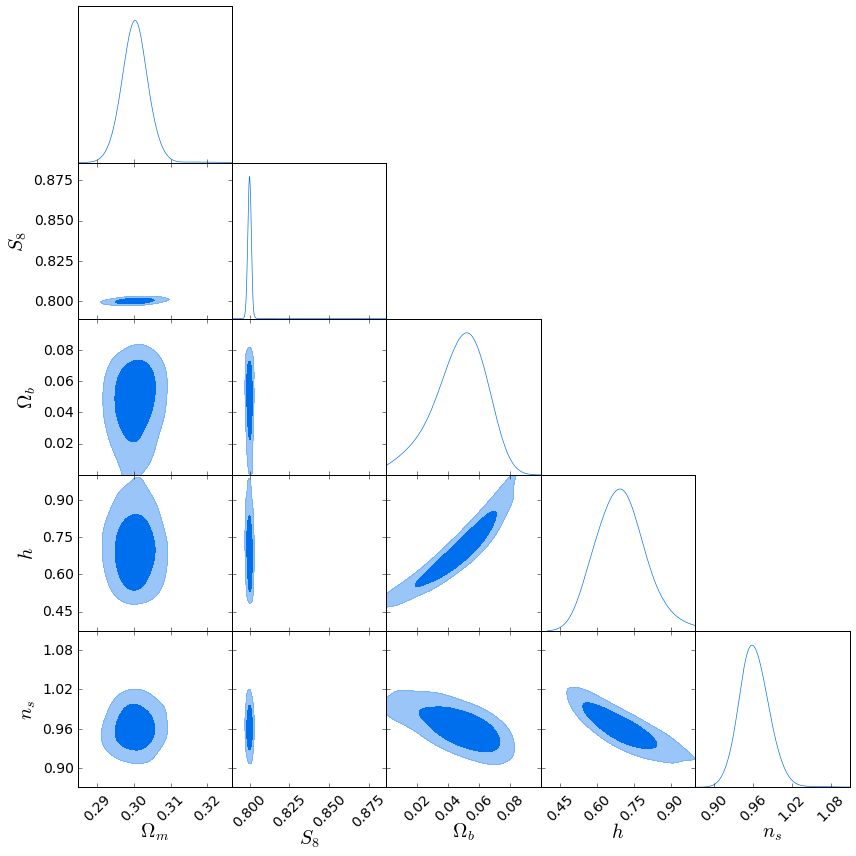

Population 12/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5850 samples, validate on 650 samples
Epoch 1/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.7482 - val_loss: 3.7711
Epoch 2/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.7622 - val_loss: 3.8091
Epoch 3/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.7253 - val_loss: 3.8195
Epoch 4/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.7396 - val_loss: 3.7607
Epoch 5/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.7247 - val_loss: 3.7533
Epoch 6/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.7143 - val_loss: 3.7339
Epoch 7/100
5850/5850 [==============================] - 8s 1ms/step - loss: 3.6938 - val_loss: 3.7173
Epoch 8/100
5850/5850 [==============================] - 9s 1ms/step - loss: 3.7184 - val_loss: 3.7469
Epoch 9/100
5850/5850 [============================

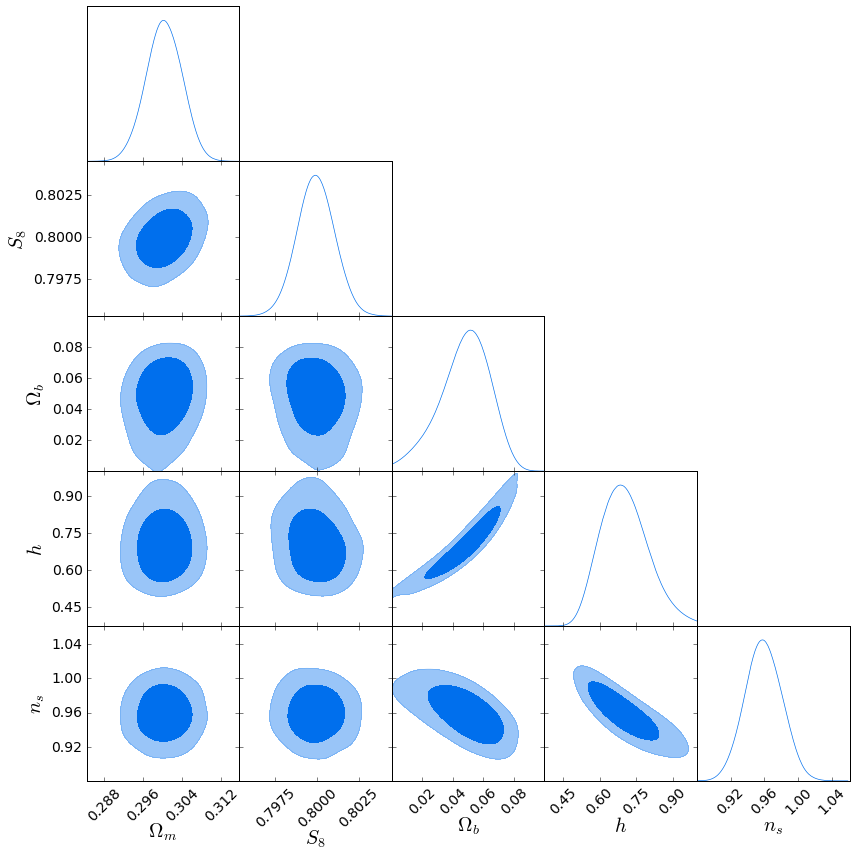

Population 13/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.6999 - val_loss: 3.6927
Epoch 2/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.6897 - val_loss: 3.7044
Epoch 3/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.7117 - val_loss: 3.6843
Epoch 4/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.6828 - val_loss: 3.6778
Epoch 5/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.6906 - val_loss: 3.7691
Epoch 6/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.7078 - val_loss: 3.7401
Epoch 7/100
6300/6300 [==============================] - 9s 1ms/step - loss: 3.7205 - val_loss: 3.6696
Epoch 8/100
6300/6300 [==============================] - 8s 1ms/step - loss: 3.6920 - val_loss: 3.6638
Epoch 9/100
6300/6300 [============================

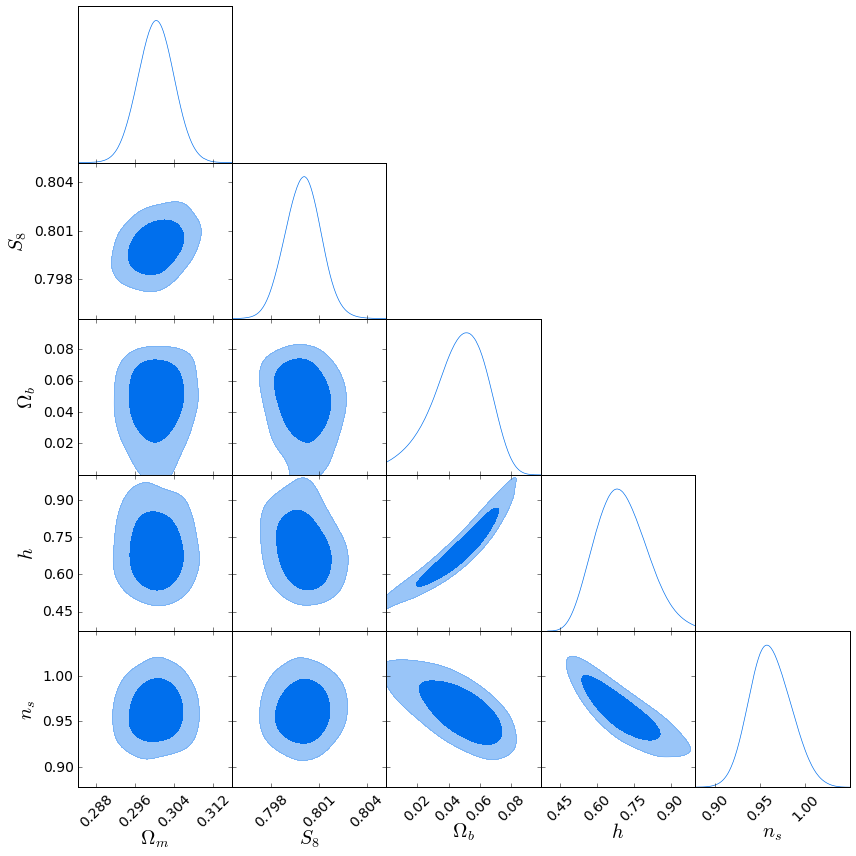

Population 14/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6985 - val_loss: 3.5156
Epoch 2/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6759 - val_loss: 3.4880
Epoch 3/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6866 - val_loss: 3.4685
Epoch 4/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6744 - val_loss: 3.4656
Epoch 5/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6884 - val_loss: 3.5521
Epoch 6/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6951 - val_loss: 3.4644
Epoch 7/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6741 - val_loss: 3.4881
Epoch 8/100
6750/6750 [==============================] - 9s 1ms/step - loss: 3.6815 - val_loss: 3.4821
Epoch 9/100
6750/6750 [============================

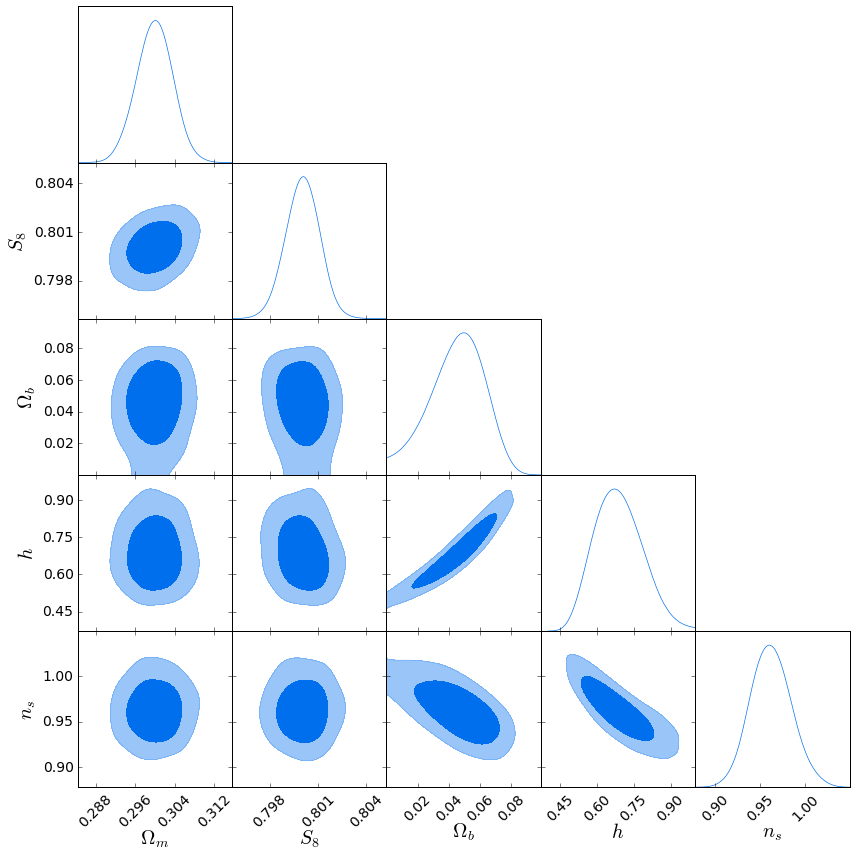

Population 15/15
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.6610 - val_loss: 3.6149
Epoch 2/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.6627 - val_loss: 3.6018
Epoch 3/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.6807 - val_loss: 3.6155
Epoch 4/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.6657 - val_loss: 3.7015
Epoch 5/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.7238 - val_loss: 3.6233
Epoch 6/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.6643 - val_loss: 3.6264
Epoch 7/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.7019 - val_loss: 3.7228
Epoch 8/100
7200/7200 [==============================] - 10s 1ms/step - loss: 3.6907 - val_loss: 3.6498
Epoch 9/100
7200/7200 [====================

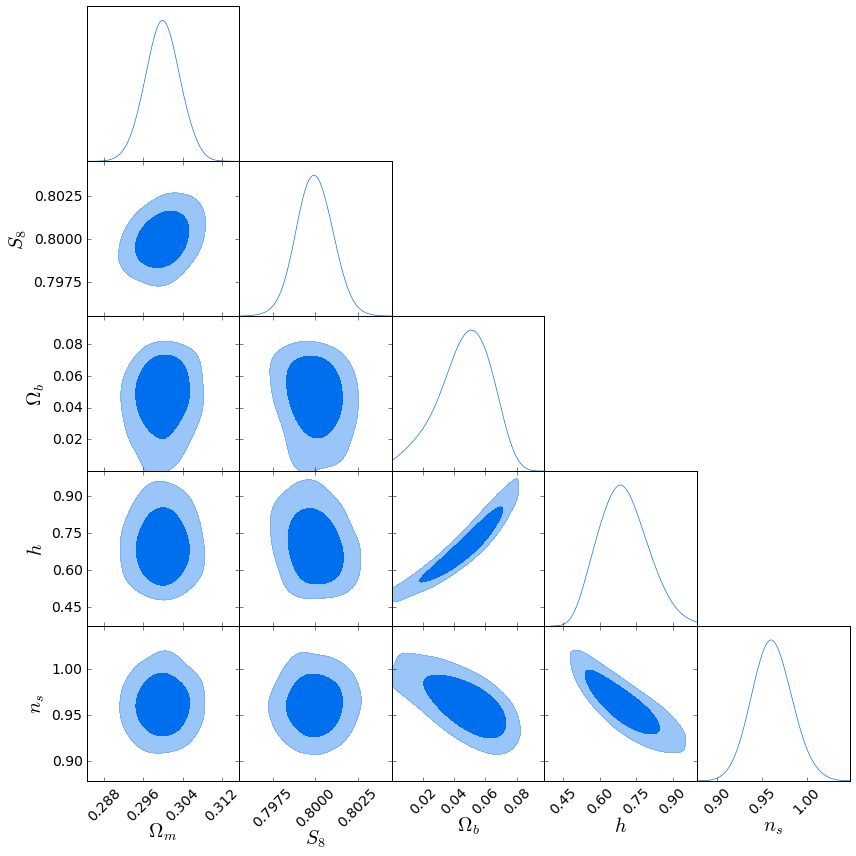

Final round of training with larger SGD batch size...
Train on 7200 samples, validate on 800 samples
Epoch 1/300
7200/7200 [==============================] - 30s 4ms/step - loss: 3.6591 - val_loss: 3.6296
Epoch 2/300
7200/7200 [==============================] - 31s 4ms/step - loss: 3.6724 - val_loss: 3.6020
Epoch 3/300
7200/7200 [==============================] - 30s 4ms/step - loss: 3.6434 - val_loss: 3.6070
Epoch 4/300
7200/7200 [==============================] - 30s 4ms/step - loss: 3.6638 - val_loss: 3.6108
Epoch 5/300
7200/7200 [==============================] - 30s 4ms/step - loss: 3.6481 - val_loss: 3.6284
Epoch 6/300
7200/7200 [==============================] - 31s 4ms/step - loss: 3.6515 - val_loss: 3.6089
Epoch 7/300
7200/7200 [==============================] - 30s 4ms/step - loss: 3.6461 - val_loss: 3.5980
Epoch 8/300
7200/7200 [==============================] - 30s 4ms/step - loss: 3.6399 - val_loss: 3.6152
Epoch 9/300
7200/7200 [==============================] - 30s 4ms/st

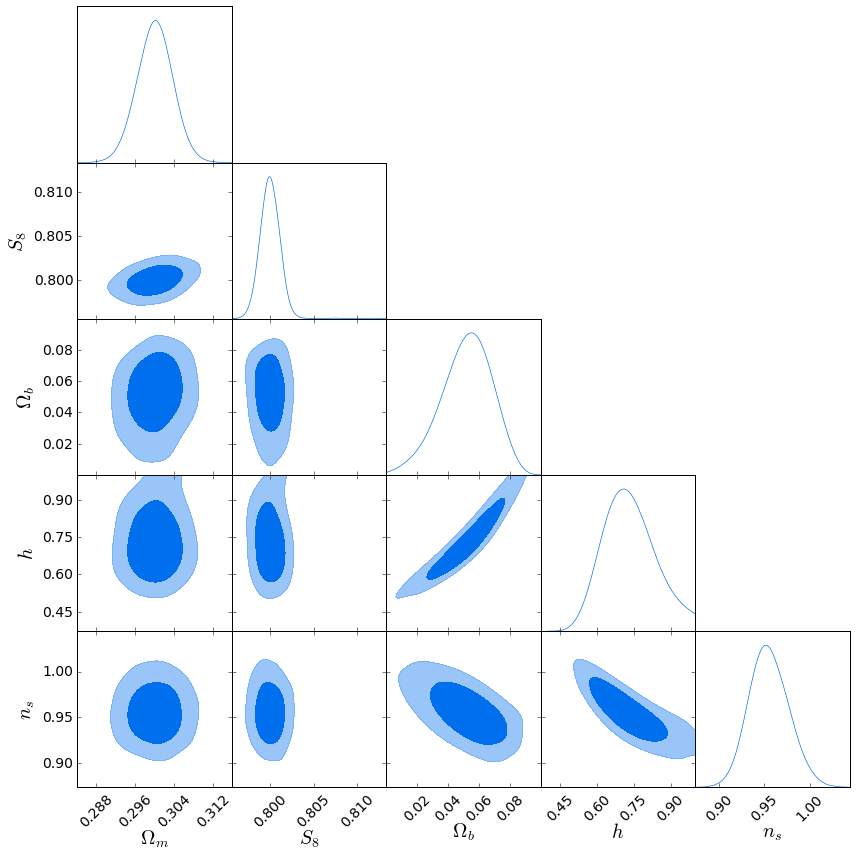

In [8]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

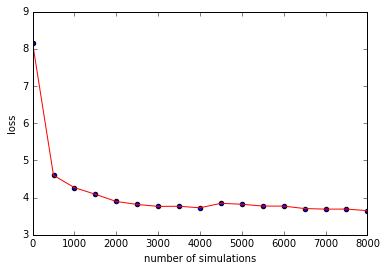

In [9]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()